Ноутбук, в котором будет оценка качества определения местоположения на идеальных данных (когда объекты не детектируются, а известно их оригинальное местоположение).

### 1. 100 точек

Для оценки качества сгенерируем 100 случайных точек, которые будут предполагаемыми местоположениями агента.

In [1]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import pickle

In [4]:
img_height = 300
img_width = 400

points_count = 100

In [16]:
y_coords = random.choices(range(img_height), k=points_count)
x_coords = random.choices(range(img_width), k=points_count)

points = list(zip(x_coords, y_coords))

In [17]:
print(len(points))
print(points[:5])

100
[(316, 231), (365, 94), (149, 172), (220, 280), (308, 13)]


In [18]:
c = Counter(points)
for k, v in c.items():
    if v > 1:
        print(k, v)

Одинаковых точек не обнаружено

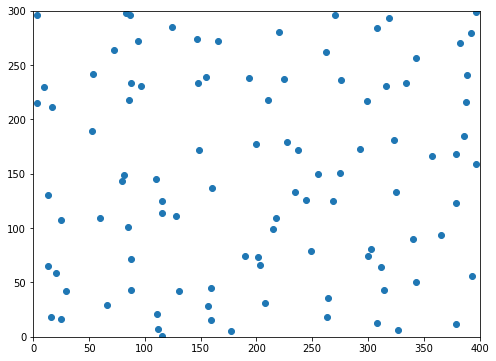

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords)
plt.xlim(0, 400)
plt.ylim(0, 300)
plt.show()

Вот такие получились точки. Сохраним их

In [30]:
with open('../dataset/100_random_points.pickle', 'wb') as f:
    pickle.dump(points, f)

### 2. Зафиксируем разбиение, и для каждой из 100 точек определим квадрат в который эта точка должна попасть

Для начала выберем разбиение, где большая сторона разбивается на 8 клеток.

In [33]:
bigger_side_split = 8
one_cell_len = img_width / bigger_side_split
print(one_cell_len)

50.0


In [34]:
centers = []

x = one_cell_len / 2
y = one_cell_len / 2

while x < img_width:
    while y < img_height:
        centers.append((x, y))
        y += one_cell_len
    y = one_cell_len / 2
    x += one_cell_len
    

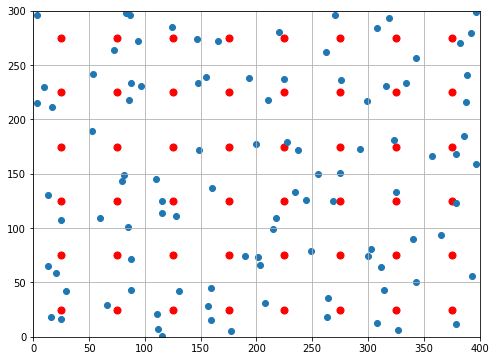

In [53]:
x_centers = [p[0] for p in centers]
y_centers = [p[1] for p in centers]

plt.figure(figsize=(8, 6))
plt.scatter(x_centers, y_centers, color='red', s=50)
plt.scatter(x_coords, y_coords)
plt.grid()
plt.xlim(0, 400)
plt.ylim(0, 300)
plt.show()

Красным цветом обозначены цетры ячеек. Синим - сгенерированные точки.

In [45]:
point_to_cell_center = {}

for x_point, y_point in points:
    center_point = None
    
    bottom_cell_y = one_cell_len
    right_cell_x = one_cell_len
    
    while bottom_cell_y <= img_height and center_point is None:
        while right_cell_x <= img_width and center_point is None:
            if x_point <= right_cell_x and y_point <= bottom_cell_y:
                center_point = (right_cell_x - (one_cell_len / 2), bottom_cell_y - (one_cell_len / 2))
            right_cell_x += one_cell_len
        right_cell_x = one_cell_len
        bottom_cell_y += one_cell_len
    
    point_to_cell_center[(x_point, y_point)] = center_point

In [50]:
c = Counter(point_to_cell_center.values())
print(c)

Counter({(325.0, 25.0): 4, (125.0, 25.0): 4, (225.0, 75.0): 4, (75.0, 125.0): 4, (75.0, 225.0): 4, (375.0, 175.0): 4, (125.0, 125.0): 4, (175.0, 25.0): 4, (75.0, 275.0): 4, (325.0, 275.0): 3, (25.0, 25.0): 3, (225.0, 125.0): 3, (375.0, 275.0): 3, (325.0, 75.0): 3, (25.0, 225.0): 3, (325.0, 225.0): 2, (375.0, 75.0): 2, (275.0, 25.0): 2, (375.0, 225.0): 2, (75.0, 25.0): 2, (275.0, 125.0): 2, (125.0, 275.0): 2, (275.0, 175.0): 2, (275.0, 275.0): 2, (275.0, 225.0): 2, (25.0, 75.0): 2, (175.0, 225.0): 2, (225.0, 225.0): 2, (225.0, 175.0): 2, (25.0, 125.0): 2, (125.0, 175.0): 1, (225.0, 275.0): 1, (325.0, 175.0): 1, (175.0, 275.0): 1, (125.0, 225.0): 1, (175.0, 75.0): 1, (175.0, 125.0): 1, (225.0, 25.0): 1, (375.0, 25.0): 1, (325.0, 125.0): 1, (75.0, 75.0): 1, (175.0, 175.0): 1, (375.0, 125.0): 1, (275.0, 75.0): 1, (25.0, 275.0): 1, (75.0, 175.0): 1})


In [51]:
len(c)

46

Какой-то ячейке повезло больше, какой-то меньше, кроме того, оказалось две ячейки, в которую не попала ни одна точка (всего ячеек 48).
Точку, которая оказалась чётко на границе ячейки относим к более левой / более верхней ячейке.

In [54]:
with open('../dataset/100_points_to_cell_centers_48cells_6x8.pickle', 'wb') as f:
    pickle.dump(point_to_cell_center, f)

### 3. Формула для вероятности попадания в нужный квадрат

После работы алгоритма определения местоположения мы получаем сетку, где каждой ячейке соответствует штраф - штраф за несоответствие круговой диаграммы агента круговой диаграмме для центра ячейки (минимальный штраф из возможных). Чем больше оказывается штраф, тем меньше, как мы полагаем, вероятность нахождения агента в этой ячейке.

Штрафы могут быть очень разными по величине (их величина зависит от количества объектов на изображении и их взаимного расположения). Поэтому будем считать за вероятность попадания в текущую ячейку следующее значение, не зависящее непосредственно от величины штрафа:

$similarity_{cell} = \max_{c \in Cell}{penalty_c} - penalty_{cell}$ - похожесть диаграммы ячейки на диаграмму агента, где cell - индекс рассматриваемой ячейки, Cell - множество всех ячеек.

$probability_{cell} = \frac{similarity_{cell}}{\Sigma_{c \in Cell}similarity_c}$

(Можно также сделать подобие softmax'a, чтобы увеличить разницу между уверенным попаданием и неуверенным, но значения вероятностей, полученных таким способом будут иметь другую интерпретацию)

Оценивать качество будем по вероятности попадания в выбранный квадрат, а не окружающие, т.к. считаем, что они изначально были выбраны достаточно большими и если точка оказалась в неподходящем квадрате, значит, это заведомо ошибка.

Понятно, что эту логику можно делать более реалистичной - например, естественно, лучше предсказать квадра, близкий к правильному, чем квадрат на другом конце картинки (особенно, когда точка, соответствующая агенту, находится близко к границе ячейки). Но, как уже было сказано ранее, в базовом варианте будем руководствоваться самой простой идеей.

Для оценки качества будем учитывать уверенность предсказания нужной ячейки. Для каждой точки посчитаем вероятность попадания в требуемый квадрат и усредним эту вероятность по всем точкам. Это и будет требуемая оценка точности для одной картинки. Посчитав эту оценку для всех картинок и усреднив её получим оценку точности предсказания местоположения на идеальных данных.

Для оценки точности будем использовать тестовую выборку.

### 4. Предсказания и оценки на тестовой выборке

#### 4.1 Функция для оценки качества на одной картинке

- Построение круговых диаграмм для изображения
- Построение круговой диаграммы агента для одной точки
- Оценка вероятности попадания в нужный квадрат для одной точки
- п 2 и 3 для всех точек
- Усреднение вероятностей попадани по всем точкам
- Повторение всех предыдущих пунктов для всех картинок
- Усреднение средней вероятности попадания по всем картинкам
- Profit

In [6]:
import os
import numpy as np
import pickle

import sys
sys.path.insert(1, '../')

from osm_object import One_OSM_object, Image_OSM_object
from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams

In [2]:
def read_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

**Построение круговых диаграмм для изображения**

In [3]:
img_id = 1
filename = str(img_id) + '.pickle'

osm_objects_path = '../dataset/osm_objects/'

In [7]:
img_osm = read_pickle(os.path.join(osm_objects_path, filename))

In [8]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

**Построение круговой диаграммы агента для одной точки**

In [9]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

agent_point = points[0][::-1]

In [10]:
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
agent_cd.make_fast()

**Оценка вероятности попадания в нужный квадрат для одной точки**

In [11]:
# аналогично select_minimum_penalty_grid из circle_diagram
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()


In [12]:
%%time
cell_probs = calculate_cells_probs(img_cds, agent_cd)

CPU times: user 401 ms, sys: 3.82 ms, total: 405 ms
Wall time: 428 ms


In [13]:
cell_probs

array([1.72625893e-02, 1.87562608e-02, 1.45287637e-02, 1.89664066e-02,
       2.14826096e-02, 2.64027794e-02, 2.46238858e-02, 2.56922275e-02,
       1.82361046e-02, 1.81308618e-02, 1.59726308e-02, 1.82504556e-02,
       2.12856726e-02, 2.00028721e-02, 2.86860033e-02, 2.75723628e-02,
       1.71645640e-02, 2.03249702e-02, 1.84593435e-02, 2.09085741e-02,
       2.35523400e-02, 1.67141025e-02, 1.68659579e-02, 3.01936597e-02,
       1.76907711e-02, 1.81723240e-02, 1.99709783e-02, 2.25995961e-02,
       1.49130517e-02, 2.28076887e-02, 1.75121792e-02, 2.21228256e-02,
       1.49887973e-02, 1.64342620e-02, 1.68711714e-02, 2.07060698e-02,
       2.13271489e-02, 2.74199310e-02, 3.92268027e-02, 2.85665917e-02,
       1.11683724e-02, 1.14807794e-12, 1.94686977e-02, 2.87075315e-02,
       2.41821939e-02, 2.31126276e-02, 2.61131988e-02, 2.58811902e-02])

In [14]:
print(cell_probs.max())

0.03922680265206529


In [15]:
cell_probs.sum()

1.0000000000000002

In [33]:
# Теперь нужно найти вероятность попадания в нужный квадрат

In [16]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [17]:
center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point[::-1]][::-1])
print(center_point_id)

38


In [18]:
# Вероятность попадания в нужный квадрат
point_prob  = cell_probs[center_point_id]
print(point_prob)

0.03922680265206529


**Круговая диаграмма агента и оценка вероятности попадания в нужный квадрат для всех точек**

In [19]:
osm_objects_path = '../dataset/osm_objects/'

bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)


def one_point_one_image_prob(img_id, points, points_to_centers):
    filename = str(img_id) + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    point_probs = []
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point[::-1]][::-1])
        
        point_probs.append(cell_probs[center_point_id])
    return np.array(point_probs).mean()

In [20]:
%%time
one_point_one_image_prob(1, points, points_to_centers)

../utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


CPU times: user 41.5 s, sys: 30.3 ms, total: 41.5 s
Wall time: 43.2 s


0.03761926787185503

**Повторение всех предыдущих пунктов для всех картинок**

In [21]:
train_val_test = read_pickle("../dataset/train_val_test_split.pickle")
test_ids = train_val_test['test']
print(len(test_ids))

4370


In [22]:
22 * 4500 / 60 / 60

27.5

27 часов это много, поэтому возьмём первые 100 картинок для оценки (они там уже перемешаны, так что ещё раз можно не перемешивать)

In [23]:
22 * 100 / 60 / 60

0.611111111111111

In [24]:
test_ids = test_ids[:100]

In [25]:
%%time
img_mean_probs = []

for i in range(len(test_ids)):
    if i % 10 == 0:
        print(i)
    img_mean_probs.append(one_point_one_image_prob(test_ids[i], points, points_to_centers))

0
10
20
30
40
50
60
70
80
90
CPU times: user 43min 50s, sys: 1.21 s, total: 43min 51s
Wall time: 43min 54s


In [26]:
print(img_mean_probs)

[0.02834625849691685, 0.03203239890075767, 0.020833333333333343, 0.024107737683666485, 0.029708978441704538, 0.03392067391149843, 0.03147462612670932, 0.030044294642357233, 0.028760343163622484, 0.037980486131553755, 0.020833333333333343, 0.02202854093080794, 0.020833333333333343, 0.026617367214571263, 0.02766813251166746, 0.035112707083855756, 0.024316029409754036, 0.03848158306988012, 0.028421809610789266, 0.032955237494786634, 0.0317620080361827, 0.04391005993241777, 0.04000222941075779, 0.02915996430429134, 0.02657925432710774, 0.024489582564964234, 0.027800625489031214, 0.027969307171532804, 0.036681833708629055, 0.030246018445186644, 0.026818752900280317, 0.026857360098749273, 0.03858871395411335, 0.027949153784152293, 0.020833333333333343, 0.033812071676407415, 0.0234119628610022, 0.036003942679435685, 0.03043676566359434, 0.02553609333055998, 0.03455143088927422, 0.03480045502896766, 0.026604035586423436, 0.026343952438164845, 0.03395066417914593, 0.03437267420639583, 0.0268969

In [27]:
print("Средняя вероятность попадания в нужный квадрат: %.4f" % np.array(img_mean_probs).mean())

Средняя вероятность попадания в нужный квадрат: 0.0276


In [28]:
# Сохраним посчинаттые средние значения
def dump_pickle(filepath, obj):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)
        
dump_pickle("../dataset/ideal_means_48cells_6x8.pickle", img_mean_probs)

### 5. То же самое на разный разбиениях

**Крупное разбиение**

In [54]:
bigger_side_blocks_count = 4
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

In [57]:
points_to_centers = {}

img_width = 400
img_height = 300
one_cell_len = img_width / bigger_side_blocks_count

for x_point, y_point in points:
    center_point = None
    
    bottom_cell_y = one_cell_len
    right_cell_x = one_cell_len
    
    while bottom_cell_y <= img_height and center_point is None:
        while right_cell_x <= img_width and center_point is None:
            if x_point <= right_cell_x and y_point <= bottom_cell_y:
                center_point = (right_cell_x - (one_cell_len / 2), bottom_cell_y - (one_cell_len / 2))
            right_cell_x += one_cell_len
        right_cell_x = one_cell_len
        bottom_cell_y += one_cell_len
    
    points_to_centers[(x_point, y_point)] = center_point

In [58]:
dump_pickle('../dataset/100_points_to_cell_centers_12cells_3x4.pickle', points_to_centers)

In [29]:
%%time
img_mean_probs_3x4 = []

for i in range(len(test_ids)):
    if i % 10 == 0:
        print(i)
    img_mean_probs_3x4.append(one_point_one_image_prob(test_ids[i], points, points_to_centers))

0
10
20
30
40
50
60
70
80
90
CPU times: user 37min 39s, sys: 452 ms, total: 37min 39s
Wall time: 37min 39s


In [30]:
print("Средняя вероятность попадания в нужный квадрат разбиение 3x4: %.4f" % np.array(img_mean_probs_3x4).mean())

Средняя вероятность попадания в нужный квадрат разбиение 3x4: 0.0276


Здесь средняя вероятность больше, но это и закономерно, квадраты же больше.

In [31]:
dump_pickle("../dataset/ideal_means_12cells_3x4.pickle", img_mean_probs_3x4)

**Более мелкое разбиение**

In [51]:
bigger_side_blocks_count = 16
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

# TODO: пересчёт points_to_centers

In [53]:
%%time
img_mean_probs_12x16 = []

for i in range(len(test_ids)): 
    if i % 10 == 0:
        print(i)
    img_mean_probs_12x16.append(one_point_one_image_prob(test_ids[i], points, points_to_centers))

0


KeyboardInterrupt: 

Ещё мельче разбивать не будем, так как рассчёт займёт слишком много времени.

### 6. Проверка того, что результат не меняется, если в диаграмме агента использовать не все объекты в пределах сектора, а только несколько ближайших

In [32]:
def cut_sectors(circle_diagram, max_len):
    for i in range(len(circle_diagram.sectors)):
        circle_diagram.sectors[i] = circle_diagram.sectors[i][:max_len]
    return circle_diagram

In [33]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)


def one_point_one_image_prob_with_cut(img_id, points, points_to_centers):
    filename = str(img_id) + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    point_probs_3 = []
    point_probs_2 = []
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
        
        # max_len = 3
        agent_cd = cut_sectors(agent_cd, max_len=3)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point[::-1]][::-1])
        
        point_probs_3.append(cell_probs[center_point_id])
        
        # max_len = 2
        agent_cd = cut_sectors(agent_cd, max_len=2)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point[::-1]][::-1])
        
        point_probs_2.append(cell_probs[center_point_id])
        
    return np.array(point_probs_3).mean(), np.array(point_probs_2).mean()

In [34]:
%%time
points_to_centers = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

img_mean_probs_6x8_max3 = []
img_mean_probs_6x8_max2 = []

for i in range(len(test_ids)):
    if i % 10 == 0:
        print(i)
    max3, max2 = one_point_one_image_prob_with_cut(test_ids[i], points, points_to_centers)
    
    img_mean_probs_6x8_max3.append(max3)
    img_mean_probs_6x8_max2.append(max2)

0
10
20
30
40
50
60
70
80
90
CPU times: user 1h 18s, sys: 1.51 s, total: 1h 19s
Wall time: 1h 20s


In [35]:
dump_pickle('../dataset/ideal_means_48cells_6x8_max3.pickle', img_mean_probs_6x8_max3)
dump_pickle('../dataset/ideal_means_48cells_6x8_max2.pickle', img_mean_probs_6x8_max2)

In [36]:
img_mean_probs = read_pickle("../dataset/ideal_means_48cells_6x8.pickle")

In [37]:
import matplotlib.pyplot as plt

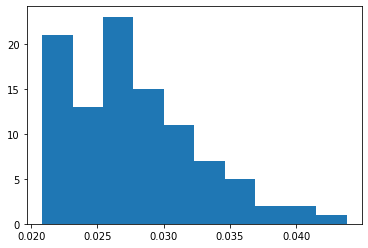

In [38]:
plt.hist(img_mean_probs_6x8_max3)
plt.show()

Распределение не похоже на нормальное, так что критерии для сравнения нормальных распределений использовать нельзя. Будем использовать критерий Манна-Уитни.

In [39]:
from scipy import stats

In [40]:
stats.mannwhitneyu(img_mean_probs, img_mean_probs_6x8_max3, alternative='two-sided')

MannwhitneyuResult(statistic=5021.5, pvalue=0.9589760119766344)

In [41]:
stats.mannwhitneyu(img_mean_probs, img_mean_probs_6x8_max2, alternative='two-sided')

MannwhitneyuResult(statistic=5048.0, pvalue=0.9073764092581523)

Ни в том, ни в другом случае гипотеза о равенстве распределений не может быть отвергнута. Значит, во-первых, несмотря на то что агент не может видеть многих объектов в силу того, что они заслоняются друг другом, ему будет достаточно двух объектов в пределах одного сектора, чтобы получить фактически с тем же качеством определённое местоположение. А во-вторых, можно использовать и при синтетических рассчётах и анализе именно диаграммы агента с не более чем 2-3 объектами в пределах сектора (хотя, конечно, прироста в скорости особенного это не даёт.

Посмотрим теперь, что произойдёт, если в пределах сектора рассматривать не более 1 объекта.

In [42]:
def one_point_one_image_prob_with_serious_cut(img_id, points, points_to_centers):
    filename = str(img_id) + '.pickle'
    
    img_osm = read_pickle(os.path.join(osm_objects_path, filename))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    point_probs_1 = []
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
        
        # max_len = 1
        agent_cd = cut_sectors(agent_cd, max_len=1)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point[::-1]][::-1])
        
        point_probs_1.append(cell_probs[center_point_id])
        
    return np.array(point_probs_1).mean()

In [43]:
%%time

img_mean_probs_6x8_max1 = []

for i in range(len(test_ids)):
    if i % 10 == 0:
        print(i)
    max1 = one_point_one_image_prob_with_serious_cut(test_ids[i], points, points_to_centers)
    
    img_mean_probs_6x8_max1.append(max1)

0


../utils.py:38: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(scalar_product / (norm_1 * norm_2)))


10
20
30
40
50
60
70
80
90
CPU times: user 30min 28s, sys: 1.02 s, total: 30min 29s
Wall time: 30min 29s


In [44]:
dump_pickle('../dataset/ideal_means_48cells_6x8_max1.pickle', img_mean_probs_6x8_max1)

In [45]:
stats.mannwhitneyu(img_mean_probs, img_mean_probs_6x8_max1, alternative='two-sided')

MannwhitneyuResult(statistic=5252.5, pvalue=0.5370665080630124)

Даже и в этом случае отклонить гипотезу о равенстве распределений не удаётся.